In [1]:
!pip install plotly kaleido
!pip install kaggle
!mkdir -p ~/.kaggle

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')
from google.colab import files
import os
from datetime import datetime, timedelta


plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Data Exploration

In [31]:
os.chdir('/content/drive/MyDrive/ml-final/ML-Final')

In [32]:
!mkdir data

In [33]:
!kaggle competitions download -c walmart-recruiting-store-sales-forecasting

  0% 0.00/2.70M [00:00<?, ?B/s]
100% 2.70M/2.70M [00:00<00:00, 96.0MB/s]


In [ ]:
!unzip -o walmart-recruiting-store-sales-forecasting.zip -d data/

In [35]:
!ls data

features.csv.zip	  stores.csv	train.csv.zip
sampleSubmission.csv.zip  test.csv.zip


In [36]:
!unzip -o data/features.csv.zip -d data/
!unzip -o data/sampleSubmission.csv.zip -d data/
!unzip -o data/test.csv.zip -d data/
!unzip -o data/train.csv.zip -d data/

Archive:  data/features.csv.zip
  inflating: data/features.csv       
Archive:  data/sampleSubmission.csv.zip
  inflating: data/sampleSubmission.csv  
Archive:  data/test.csv.zip
  inflating: data/test.csv           
Archive:  data/train.csv.zip
  inflating: data/train.csv          


# Data Exploration

In [37]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
stores = pd.read_csv('data/stores.csv')
features = pd.read_csv('data/features.csv')

In [11]:
print("=" * 50)
print("TRAIN DATASET OVERVIEW")
print("=" * 50)
print(train.head())
print("\nData Types:")
print(train.dtypes)
print("\nBasic Statistics:")
print(train.describe())

print("\n" + "=" * 50)
print("TEST DATASET OVERVIEW")
print("=" * 50)
print(test.head())
print("\nData Types:")
print(test.dtypes)

print("\n" + "=" * 50)
print("STORES DATASET OVERVIEW")
print("=" * 50)
print(stores.head())
print("\nStore Types Distribution:")
print(stores['Type'].value_counts())
print("\nStore Size Statistics:")
print(stores['Size'].describe())

print("\n" + "=" * 50)
print("FEATURES DATASET OVERVIEW")
print("=" * 50)
print(features.head())
print("\nData Types:")
print(features.dtypes)
print("\nBasic Statistics:")
print(features.describe())

TRAIN DATASET OVERVIEW
   Store  Dept        Date  Weekly_Sales  IsHoliday
0      1     1  2010-02-05      24924.50      False
1      1     1  2010-02-12      46039.49       True
2      1     1  2010-02-19      41595.55      False
3      1     1  2010-02-26      19403.54      False
4      1     1  2010-03-05      21827.90      False

Data Types:
Store             int64
Dept              int64
Date             object
Weekly_Sales    float64
IsHoliday          bool
dtype: object

Basic Statistics:
               Store           Dept   Weekly_Sales
count  421570.000000  421570.000000  421570.000000
mean       22.200546      44.260317   15981.258123
std        12.785297      30.492054   22711.183519
min         1.000000       1.000000   -4988.940000
25%        11.000000      18.000000    2079.650000
50%        22.000000      37.000000    7612.030000
75%        33.000000      74.000000   20205.852500
max        45.000000      99.000000  693099.360000

TEST DATASET OVERVIEW
   Store  Dept   

In [12]:
def preprocess_for_analysis():

    train['Date'] = pd.to_datetime(train['Date'])
    test['Date'] = pd.to_datetime(test['Date'])
    features['Date'] = pd.to_datetime(features['Date'])
    train_merged = train.merge(features, on=['Store', 'Date'], how='left')
    train_merged = train_merged.merge(stores, on='Store', how='left')
    train_merged['Year'] = train_merged['Date'].dt.year
    train_merged['Month'] = train_merged['Date'].dt.month
    train_merged['Week'] = train_merged['Date'].dt.isocalendar().week
    train_merged['Day'] = train_merged['Date'].dt.day
    train_merged['DayOfYear'] = train_merged['Date'].dt.dayofyear
    train_merged['WeekOfYear'] = train_merged['Date'].dt.isocalendar().week
    return train_merged

train_full = preprocess_for_analysis()
print(f"Merged training data shape: {train_full.shape}")
print(f"Date range: {train_full['Date'].min()} to {train_full['Date'].max()}")

Merged training data shape: (421570, 23)
Date range: 2010-02-05 00:00:00 to 2012-10-26 00:00:00


In [15]:
def analyze_missing_data():
    missing_data = pd.DataFrame({
        'Column': train_full.columns,
        'Missing_Count': train_full.isnull().sum(),
        'Missing_Percentage': (train_full.isnull().sum() / len(train_full)) * 100
    })
    missing_data = missing_data[missing_data['Missing_Count'] > 0].sort_values('Missing_Percentage', ascending=False)

    print("Missing Data Summary:")
    print(missing_data)
    return missing_data

missing_analysis = analyze_missing_data()

Missing Data Summary:
              Column  Missing_Count  Missing_Percentage
MarkDown2  MarkDown2         310322           73.611025
MarkDown4  MarkDown4         286603           67.984676
MarkDown3  MarkDown3         284479           67.480845
MarkDown1  MarkDown1         270889           64.257181
MarkDown5  MarkDown5         270138           64.079038


In [17]:
def analyze_target_variable():
    print("Weekly Sales Statistics:")
    print(train_full['Weekly_Sales'].describe())
    print(f"\nNegative sales count: {(train_full['Weekly_Sales'] < 0).sum()}")
    print(f"Zero sales count: {(train_full['Weekly_Sales'] == 0).sum()}")
    print(f"Percentage of negative sales: {(train_full['Weekly_Sales'] < 0).mean() * 100:.2f}%")

analyze_target_variable()

Weekly Sales Statistics:
count    421570.000000
mean      15981.258123
std       22711.183519
min       -4988.940000
25%        2079.650000
50%        7612.030000
75%       20205.852500
max      693099.360000
Name: Weekly_Sales, dtype: float64

Negative sales count: 1285
Zero sales count: 73
Percentage of negative sales: 0.30%


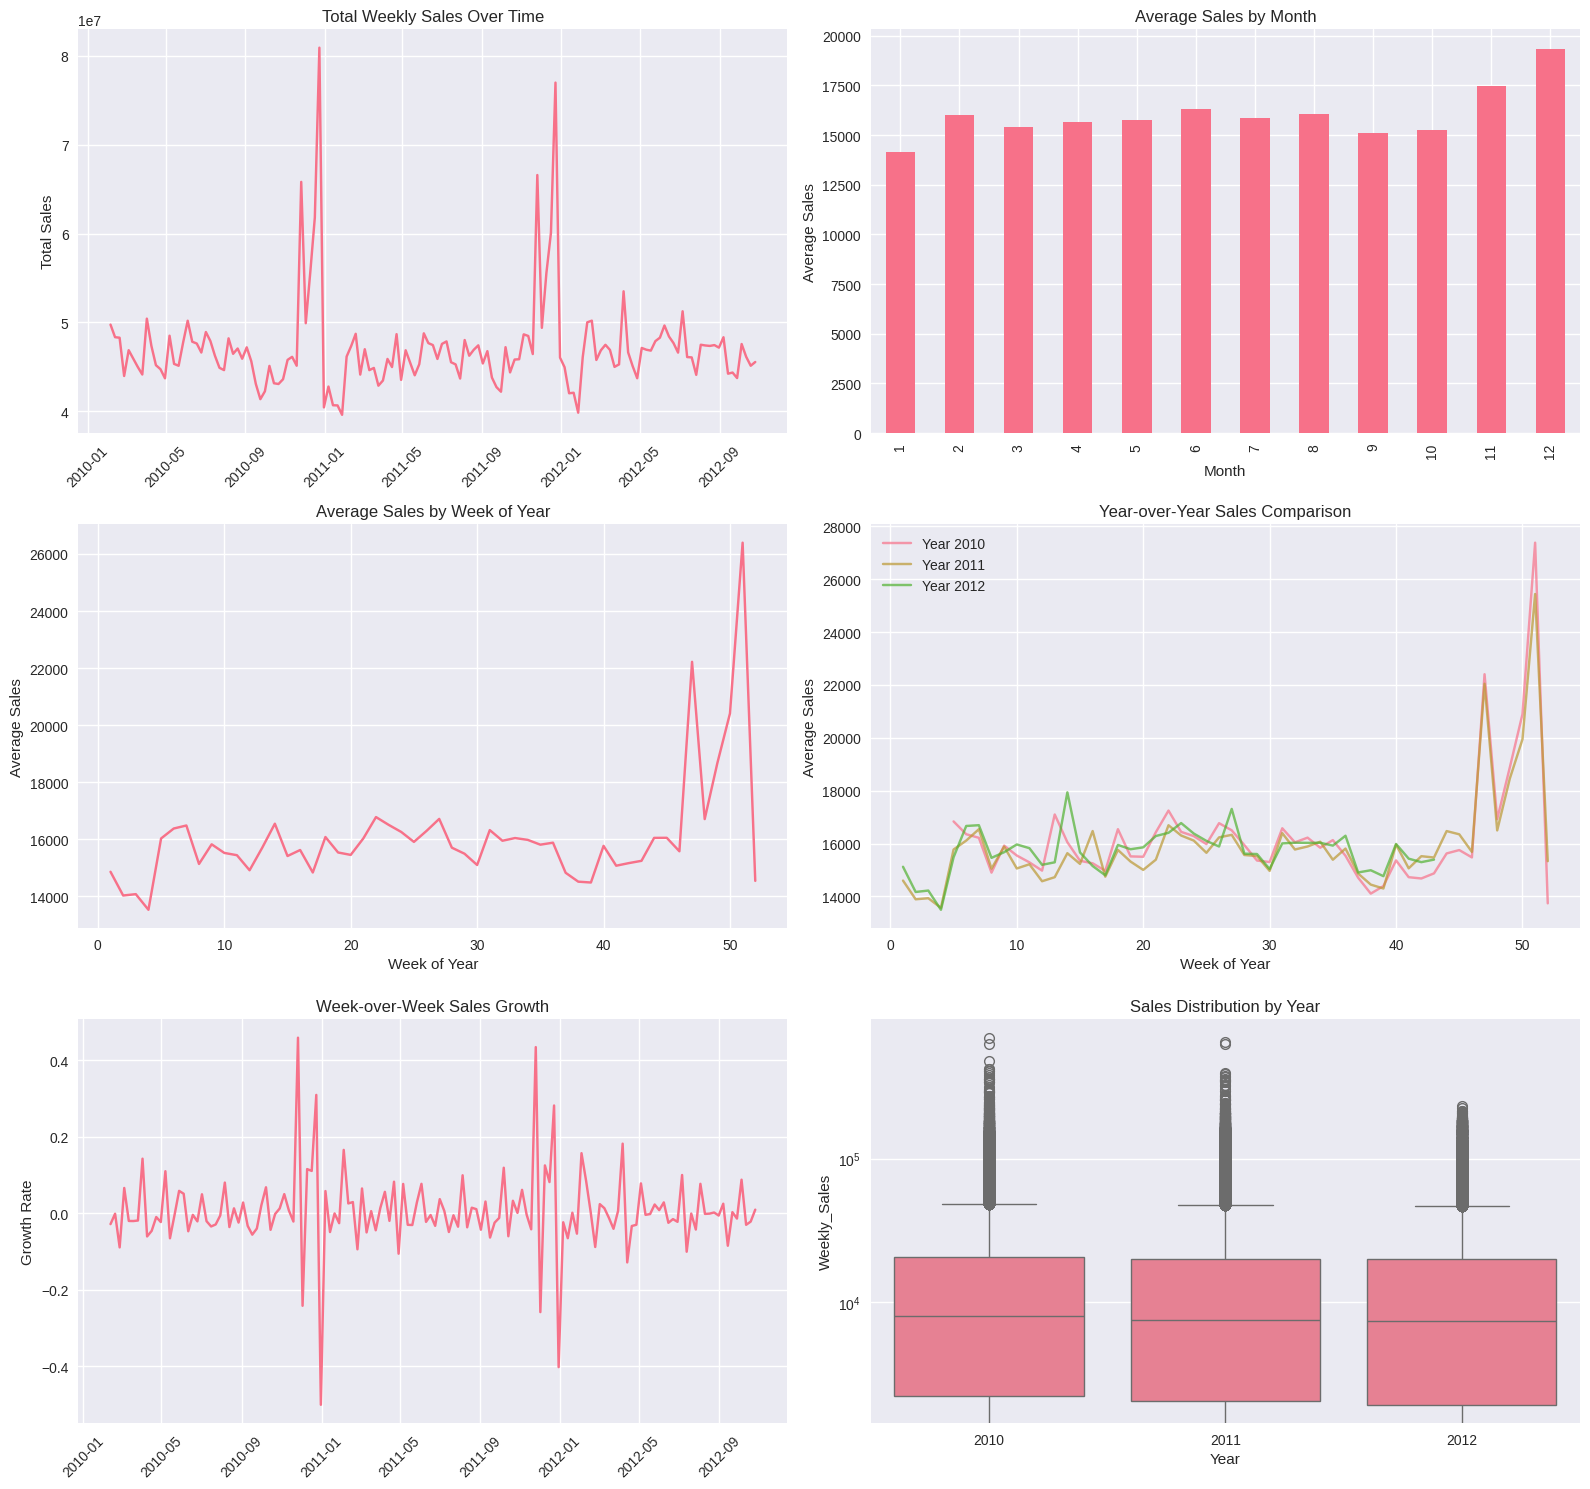


Seasonality Insights:
Highest sales month: 12 (avg: $19,355.70)
Lowest sales month: 1 (avg: $14,126.08)
Peak week of year: 51 (avg: $26,396.40)


In [19]:
def analyze_time_patterns():
    weekly_sales = train_full.groupby('Date')['Weekly_Sales'].sum().reset_index()
    monthly_sales = train_full.groupby(['Year', 'Month'])['Weekly_Sales'].sum().reset_index()

    fig, axes = plt.subplots(3, 2, figsize=(16, 15))
    axes[0,0].plot(weekly_sales['Date'], weekly_sales['Weekly_Sales'])
    axes[0,0].set_title('Total Weekly Sales Over Time')
    axes[0,0].set_ylabel('Total Sales')
    axes[0,0].tick_params(axis='x', rotation=45)
    monthly_pattern = train_full.groupby('Month')['Weekly_Sales'].mean()
    monthly_pattern.plot(kind='bar', ax=axes[0,1])
    axes[0,1].set_title('Average Sales by Month')
    axes[0,1].set_ylabel('Average Sales')

    # Weekly patterns
    weekly_pattern = train_full.groupby('WeekOfYear')['Weekly_Sales'].mean()
    axes[1,0].plot(weekly_pattern.index, weekly_pattern.values)
    axes[1,0].set_title('Average Sales by Week of Year')
    axes[1,0].set_xlabel('Week of Year')
    axes[1,0].set_ylabel('Average Sales')

    # Year-over-year comparison
    for year in train_full['Year'].unique():
        year_data = train_full[train_full['Year'] == year]
        weekly_year = year_data.groupby('WeekOfYear')['Weekly_Sales'].mean()
        axes[1,1].plot(weekly_year.index, weekly_year.values, label=f'Year {year}', alpha=0.7)
    axes[1,1].set_title('Year-over-Year Sales Comparison')
    axes[1,1].set_xlabel('Week of Year')
    axes[1,1].set_ylabel('Average Sales')
    axes[1,1].legend()

    # Sales growth over time
    weekly_sales['Sales_Growth'] = weekly_sales['Weekly_Sales'].pct_change()
    axes[2,0].plot(weekly_sales['Date'], weekly_sales['Sales_Growth'])
    axes[2,0].set_title('Week-over-Week Sales Growth')
    axes[2,0].set_ylabel('Growth Rate')
    axes[2,0].tick_params(axis='x', rotation=45)

    # Distribution of sales by year
    sns.boxplot(data=train_full, x='Year', y='Weekly_Sales', ax=axes[2,1])
    axes[2,1].set_title('Sales Distribution by Year')
    axes[2,1].set_yscale('log')

    plt.tight_layout()
    plt.show()

    print("\nSeasonality Insights:")
    print(f"Highest sales month: {monthly_pattern.idxmax()} (avg: ${monthly_pattern.max():,.2f})")
    print(f"Lowest sales month: {monthly_pattern.idxmin()} (avg: ${monthly_pattern.min():,.2f})")
    print(f"Peak week of year: {weekly_pattern.idxmax()} (avg: ${weekly_pattern.max():,.2f})")

analyze_time_patterns()

In [24]:
def analyze_holiday_impact():
    holidays = {
        'Super Bowl': ['2010-02-12', '2011-02-11', '2012-02-10'],
        'Labor Day': ['2010-09-10', '2011-09-09', '2012-09-07'],
        'Thanksgiving': ['2010-11-26', '2011-11-25', '2012-11-23'],
        'Christmas': ['2010-12-31', '2011-12-30', '2012-12-28']
    }

    holiday_dates = []
    for holiday, dates in holidays.items():
        for date in dates:
            holiday_dates.append(pd.to_datetime(date))

    holiday_sales = train_full[train_full['IsHoliday_x'] == True]['Weekly_Sales']
    non_holiday_sales = train_full[train_full['IsHoliday_x'] == False]['Weekly_Sales']

    print(f"Average holiday sales: ${holiday_sales.mean():,.2f}")
    print(f"Average non-holiday sales: ${non_holiday_sales.mean():,.2f}")
    print(f"Holiday sales premium: {(holiday_sales.mean() / non_holiday_sales.mean() - 1) * 100:.2f}%")

analyze_holiday_impact()

Average holiday sales: $17,035.82
Average non-holiday sales: $15,901.45
Holiday sales premium: 7.13%


In [25]:
def analyze_store_dept_performance():
    store_metrics = train_full.groupby('Store').agg({
        'Weekly_Sales': ['mean', 'std', 'sum', 'count'],
        'Size': 'first',
        'Type': 'first'
    }).round(2)

    store_metrics.columns = ['Avg_Sales', 'Sales_Std', 'Total_Sales', 'Weeks_Count', 'Store_Size', 'Store_Type']
    store_metrics['CV'] = (store_metrics['Sales_Std'] / store_metrics['Avg_Sales']).round(2)

    print("Top 10 Stores by Average Sales:")
    print(store_metrics.sort_values('Avg_Sales', ascending=False).head(10))

    # Department performance
    dept_metrics = train_full.groupby('Dept').agg({
        'Weekly_Sales': ['mean', 'std', 'sum', 'count']
    }).round(2)

    dept_metrics.columns = ['Avg_Sales', 'Sales_Std', 'Total_Sales', 'Weeks_Count']
    dept_metrics['CV'] = (dept_metrics['Sales_Std'] / dept_metrics['Avg_Sales']).round(2)

    print("\nTop 10 Departments by Average Sales:")
    print(dept_metrics.sort_values('Avg_Sales', ascending=False).head(10))

    return store_metrics, dept_metrics

store_perf, dept_perf = analyze_store_dept_performance()

Top 10 Stores by Average Sales:
       Avg_Sales  Sales_Std   Total_Sales  Weeks_Count  Store_Size Store_Type  \
Store                                                                           
20      29508.30   35661.53  3.013978e+08        10214      203742          A   
4       29161.21   34583.68  2.995440e+08        10272      205863          A   
14      28784.85   36911.12  2.889999e+08        10040      200898          A   
13      27355.14   33853.47  2.865177e+08        10474      219622          A   
2       26898.07   33077.61  2.753824e+08        10238      202307          A   
10      26332.30   32133.01  2.716177e+08        10315      126512          B   
27      24826.98   29718.92  2.538559e+08        10225      204184          A   
6       21913.24   23633.43  2.237561e+08        10211      202505          A   
1       21710.54   27748.95  2.224028e+08        10244      151315          A   
39      21000.76   25373.75  2.074455e+08         9878      184109          A

In [27]:
def analyze_external_features():
    numeric_features = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Weekly_Sales']
    correlation_matrix = train_full[numeric_features].corr()

    print("Correlation with Weekly Sales:")
    sales_corr = correlation_matrix['Weekly_Sales'].sort_values(ascending=False)
    print(sales_corr)

    markdown_cols = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
    markdown_data = train_full[train_full[markdown_cols].notna().any(axis=1)]

analyze_external_features()

Correlation with Weekly Sales:
Weekly_Sales    1.000000
Fuel_Price     -0.000120
Temperature    -0.002312
CPI            -0.020921
Unemployment   -0.025864
Name: Weekly_Sales, dtype: float64
